In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
from sklearn import model_selection, preprocessing, svm, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [122]:
stock_list = ["AC.PA", "AI.PA", "AIR.PA", "ATO.PA", "BNP.PA", "EN.PA", "CAP.PA", "CA.PA", "ACA.PA", 
          "BN.PA", "ENGI.PA", "KER.PA", "OR.PA", "LHN.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA",
          "UG.PA", "SGO.PA", "SAN.PA", "SU.PA", "GLE.PA", "SW.PA", "FP.PA", "FR.PA", "VIE.PA", "DG.PA", "VIV.PA"]

In [123]:
class Open_csv:
    
    def __init__(self):
        pass
    
    def open(self,path_to_file):
        data = np.asarray(pd.read_csv(path_to_file, delimiter=",").values)
        return data

In [109]:
def f_1(vector):
    return (vector[2]-vector[3])/(vector[1]+vector[4]) # (high-low)/(open+close)

In [124]:
# garman-klass
def f(vector):
    # vector[1] = open ; vector[2] = high ; vector[3] = low ; vector[4] = close
    return 12*(np.log(vector[2]/vector[3])**2)-(2*np.log(2)-1)*(np.log(vector[4]/vector[1])**2)

In [133]:
# parkinson
def f(vector):
    # vector[1] = open ; vector[2] = high ; vector[3] = low ; vector[4] = close
    return np.log(vector[2]/vector[3])

In [134]:
class Preprocess_data:
    
    def __init__(self):
        self.function = f_1
        self.open_csv = Open_csv()
        self.data = None
        self.returns = []
        self.log_returns = True
        self.depth = 5
        self.X_ = None
        self.X_all = None
        self.y_ = None
        self.y_all = None     
        
    def get_data_stock(self,stock_name):
        self.data = self.open_csv.open("data/"+stock_name+".csv")
    
    def get_stock_return(self):
        for i in range(len(self.data)):
            self.returns.append(self.function(self.data[i]))
        self.returns = np.asarray(self.returns)
        
    def show_distribution_log_returns(self):
        plt.hist(np.log(self.returns),bins=200)
        plt.title("log(returns)")
        plt.show()
        mu = np.mean(np.log(stock_returns[0]))
        sigma = np.std(np.log(stock_returns[0]))
        s = np.random.normal(mu, sigma, 1300)
        plt.hist(s, bins=200, normed=True)
        plt.title("Normal(mean(log(returns)),std(log(returns)))")
        plt.show()
        
    def get_log_returns(self):
        if self.log_returns:
            temp = np.empty(len(np.where(self.returns!=0)[0]))
            for i in range(len(np.where(self.returns!=0)[0])):
                temp[i] = self.returns[np.where(self.returns!=0)[0][i]]
            self.returns = (np.log(temp)-np.mean(np.log(temp)))/np.std(np.log(temp))  # loi normale centree reduite
            
    def compute_X_and_y(self):
        self.X_ = []
        self.y_ = []
        for i in range(len(self.returns)-self.depth):
            temp = self.returns
            self.y_.append(temp[i])
            self.X_.append(np.array(temp[i+1:i+1+self.depth]))
        self.y_ = np.array(self.y_)        
        temp2 = np.empty((len(self.X_)-1,len(self.X_[0])))
        for i in range(len(temp2)):
            temp2[i] = np.array(self.X_[i])
        self.X_ = temp2
        self.y_ = self.y_[:len(self.X_)]
        
    def focus_on_recent_data(self):
        n_data_for_training = 500
        start_index = 0
        self.X_, self.X_all = self.X_[start_index:start_index+n_data_for_training], self.X_
        self.y_, self.y_all = self.y_[start_index:start_index+n_data_for_training], self.y_
    
    def run(self,stock_name,focus_on_recent_data):
        self.get_data_stock(stock_name)
        self.get_stock_return()
        self.get_log_returns()
        self.compute_X_and_y()
        if focus_on_recent_data:
            self.focus_on_recent_data()

In [135]:
class Estimate:
    
    def __init__(self):
        self.X_ = None
        self.y_ = None
        self.optimize_rf = True
        self.optimize_svm = True
        self.ypred_randomforest = None
        self.ypred_svm = None
    
    def cross_validate(self, design_matrix, labels, regressor, cv_folds):
        pred = np.zeros(labels.shape) # Hold all predictions, in correct order.
        for tr, te in cv_folds:        
            scaler = preprocessing.StandardScaler()
            Xtr = scaler.fit_transform(design_matrix[tr,:])
            ytr = labels[tr]
            Xte = scaler.transform(design_matrix[te,:])
            regressor.fit(Xtr, ytr)
            pred[te] = (regressor.predict(Xte))
        return pred

    def random_forest_estimate(self):
        # Set up a stratified 10-fold cross-validation
        skf = model_selection.KFold(n_splits=10)
        skf.get_n_splits(self.X_, self.y_)
        folds = [(tr,te) for (tr,te) in skf.split(self.X_, self.y_)]
        
        if self.optimize_rf:
            param_grid = {'n_estimators':[1,10],
                    'max_features':[1,4],
                    'max_depth':[1,9]}

            clf_rf = GridSearchCV(RandomForestRegressor(),
                           param_grid)

            self.ypred_randomforest = self.cross_validate(self.X_, self.y_, clf_rf, folds)

        else:
            self.ypred_randomforest = self.cross_validate(self.X_,self.y_,RandomForestRegressor(),folds)
    
    def svm_estimate(self):
        # Set up a stratified 10-fold cross-validation
        skf = model_selection.KFold(n_splits=10)
        skf.get_n_splits(self.X_, self.y_)
        folds = [(tr,te) for (tr,te) in skf.split(self.X_, self.y_)]
        if self.optimize_svm:
            param_grid = {'C':[0.01,10]}

            clf_svm = GridSearchCV(svm.SVR(kernel='linear'),
                           param_grid)

            self.ypred_svm = self.cross_validate(self.X_, self.y_, clf_svm, folds)

        else:
            self.ypred_svm = self.cross_validate(self.X_, self.y_, svm.SVR(kernel='linear'), folds)
            
    def run(self,X_,y_):
        self.X_ = X_
        self.y_ = y_
        self.random_forest_estimate()
        self.svm_estimate()

In [136]:
preprocess_data = Preprocess_data()
estimate = Estimate()

In [137]:
preprocess_data.run("FP.PA",
                   focus_on_recent_data=True)

In [138]:
estimate.run(preprocess_data.X_,preprocess_data.y_)

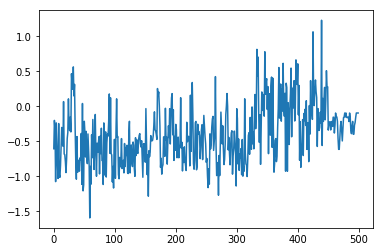

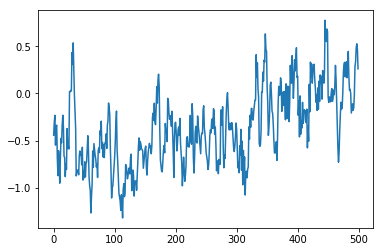

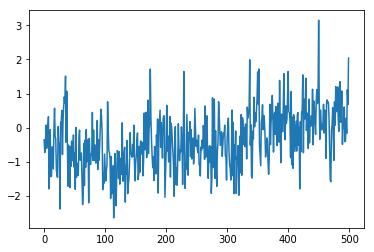

In [139]:
plt.plot(ypred_randomforest)
plt.show()
plt.plot(ypred_svm)
plt.show()
plt.plot(y_)
plt.show()

In [140]:
ypred_randomforest = estimate.ypred_randomforest
ypred_svm = estimate.ypred_svm
y_ = estimate.y_

In [141]:
# comparaison avec différents prédicteurs "stupides"
y1_ = np.array([np.mean(y_)]*len(y_))
print("dummy estimator : mean of |y1_ - y_|   :   "+str(np.mean(np.abs(y1_-y_))))
print("dummy estimator : explained variance : "+str(metrics.explained_variance_score(y_,y1_)))
print("dummy estimator : mean absolute error : "+str(metrics.mean_absolute_error(y_,y1_)))
print("dummy estimator : mean squared error : "+str(metrics.mean_squared_error(y_,y1_)))
print("dummy estimator : r2 score : "+str(metrics.r2_score(y_,y1_)))
    
# random forest
print("randomforest : mean of |ypred_randomforest - y_|   :   "+str(np.mean(np.abs(ypred_randomforest-y_))))
print("randomforest : explained variance : "+str(metrics.explained_variance_score(y_,ypred_randomforest)))
print("randomforest : mean absolute error : "+str(metrics.mean_absolute_error(y_,ypred_randomforest)))
print("randomforest : mean squared error : "+str(metrics.mean_squared_error(y_,ypred_randomforest)))
print("randomforest : r2 score : "+str(metrics.r2_score(y_,ypred_randomforest)))
    
# svm
print("svm : mean of |ypred_svm - y_|   :   "+str(np.mean(np.abs(ypred_svm-y_))))
print("svm : explained variance : "+str(metrics.explained_variance_score(y_,ypred_svm)))
print("svm : mean absolute error : "+str(metrics.mean_absolute_error(y_,ypred_svm)))
print("svm : mean squared error : "+str(metrics.mean_squared_error(y_,ypred_svm)))
print("svm : r2 score : "+str(metrics.r2_score(y_,ypred_svm)))

dummy estimator : mean of |y1_ - y_|   :   0.6828702946339802
dummy estimator : explained variance : 0.0
dummy estimator : mean absolute error : 0.6828702946339802
dummy estimator : mean squared error : 0.7129551184039646
dummy estimator : r2 score : 0.0
randomforest : mean of |ypred_randomforest - y_|   :   0.639947880289453
randomforest : explained variance : 0.0690228958348934
randomforest : mean absolute error : 0.639947880289453
randomforest : mean squared error : 0.6638050859013122
randomforest : r2 score : 0.06893846643906665
svm : mean of |ypred_svm - y_|   :   0.6032010126864337
svm : explained variance : 0.18657150576733572
svm : mean absolute error : 0.6032010126864337
svm : mean squared error : 0.5799738676274501
svm : r2 score : 0.18652120918103376
